In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import umap
import copy
import hdbscan
from imblearn.under_sampling import RandomUnderSampler
from multiprocessing import Pool
import os
from datetime import datetime
import math
# data manipulation
import pandas as pd

# data viz
from matplotlib import rcParams
import seaborn as sns

# apply some cool styling
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12,  6)

In [9]:
def magnitude(sample):
    mag_vector = []
    for s in sample:
        mag_vector.append(math.sqrt(sum([s[0]**2, s[1]**2, s[2]**2])))
    return mag_vector


def feature_extraction(X):
    """
    Derive three activity intensity cues: mean and standard deviation of activity intensity,
    and duration of immobility during assessment window to summarize the data.
    """
    features = []
    for sample in X:
        mag = magnitude(sample)
        ft_mean = np.mean(mag)
        ft_std = np.std(mag)
        # calculate duration of immobility
        features.append([ft_mean, ft_std])

    return features


def get_cmap(n, name='gist_rainbow'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)



def print_by_class(n_class, finalDf, exp_name, y_new):
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('First Component', fontsize=15)
    ax.set_ylabel('Second Component', fontsize=15)
    ax.set_title(exp_name, fontsize=20)
    cmap = get_cmap(n_class, name='Set1')
    targets = np.unique(y_new)
    colors = []
    for i in range(n_class):
        colors.append(cmap(i))

    for target, color in zip(targets, colors):
        indicesToKeep = finalDf['label'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'First Component']
                   , finalDf.loc[indicesToKeep, 'Second Component']
                   , color=color
                   , s=50)
    ax.legend(targets)
    ax.grid()
    plt.show()
    #plt.savefig(exp_name + '.png')


In [3]:
np.random.seed(42)
n_class = 2
path = "/home/jsenadesouza/DA-healthy2patient/results/outcomes/classifier_results/IMUTransformers/missclassified/"
folds = []
folds.append(np.load(os.path.join(path, "predtest_1.npz"), allow_pickle=True))
folds.append(np.load(os.path.join(path, "predtest_2.npz"), allow_pickle=True))
folds.append(np.load(os.path.join(path, "predtest_3.npz"), allow_pickle=True))
folds.append(np.load(os.path.join(path, "predtest_4.npz"), allow_pickle=True))
folds.append(np.load(os.path.join(path, "predtest_0.npz"), allow_pickle=True))

miss_samples = []
miss_labels = []
for fold in folds:
    pred = fold["predicted"]
    true = fold["ground_truth"]
    samples = fold["samples"]
    for p, t, s in zip(pred, true, samples):
        if p != t:
            miss_samples.append(s)
            miss_labels.append(t)
    

X_feat = feature_extraction(miss_samples)

In [ ]:
embedding = umap.UMAP(
    n_neighbors=10,
    min_dist=0.0,
    n_components=2,
    random_state=42#,
    #metric='cosine'
).fit_transform(X_feat)

principalDf = pd.DataFrame(data=embedding, columns=['First Component', 'Second Component'])

labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(embedding)


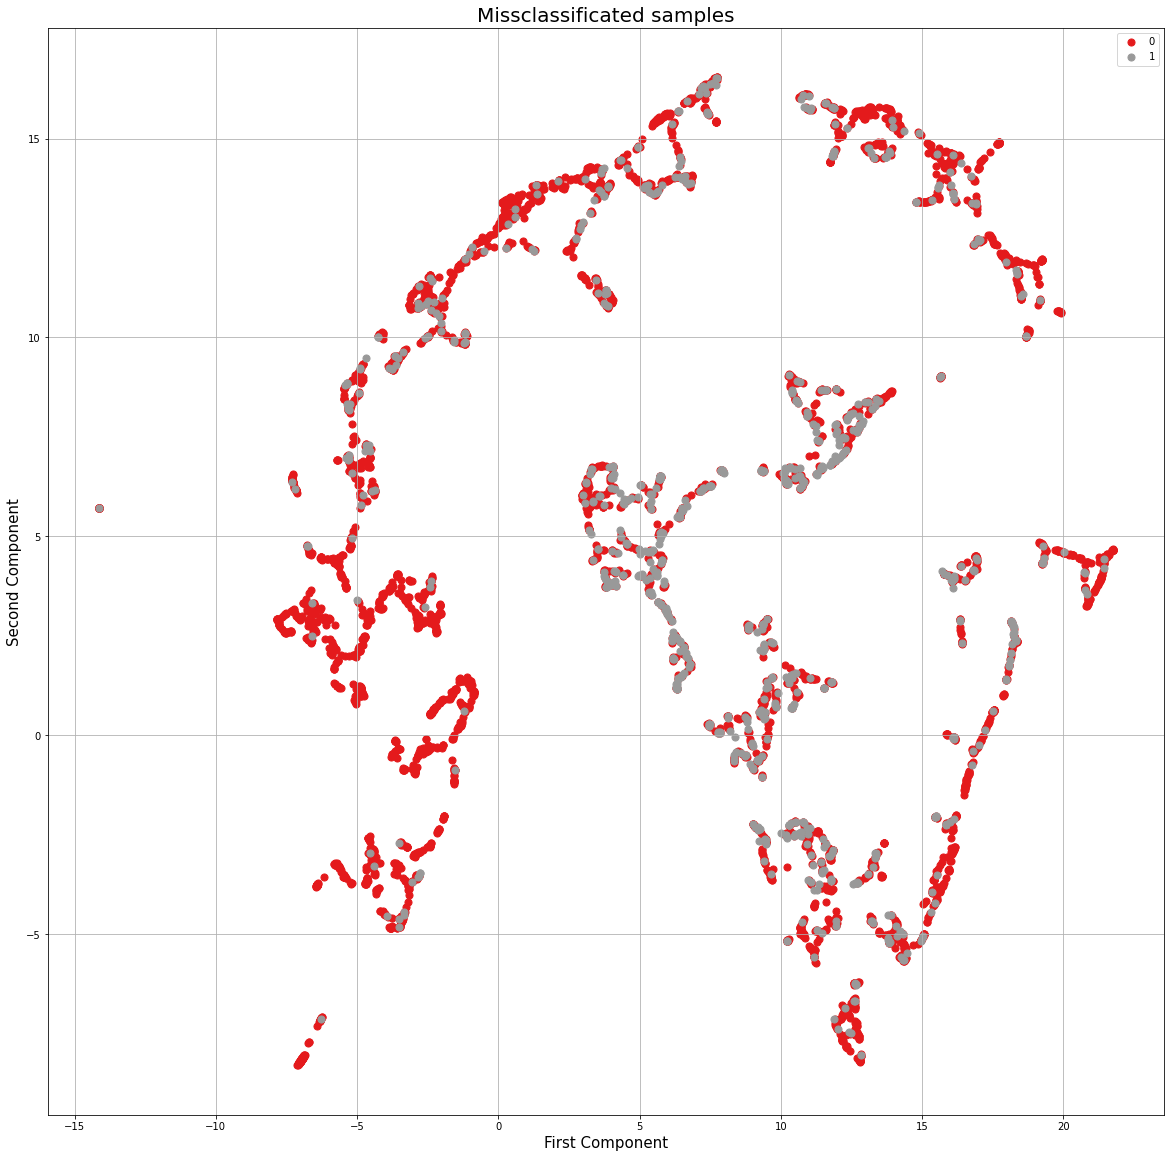

In [10]:
yDf = pd.DataFrame(data=np.array(miss_labels), columns=['label'])
finalDf = pd.concat([principalDf, yDf], axis=1)
exp_name = "Missclassificated samples"
print_by_class(n_class, finalDf, exp_name, miss_labels)